In [3]:
import numpy as np
import pandas as pd

In [6]:
import sklearn
import chardet

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
with open("data/SMSSpamCollection","rb") as f:
    result = chardet.detect(f.read())
print(result['encoding'])
df_raw = pd.read_csv("data/SMSSpamCollection",sep='\t',names=["v1","v2"],encoding=result['encoding'])

utf-8


In [9]:
df_raw.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
df=df_raw[['v1','v2']].rename(columns={'v1':'label','v2':'sms'})

In [11]:
df.head()

,label,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [12]:
df.describe()

,label,sms
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [13]:
df.drop_duplicates(subset="sms",inplace=True)

In [14]:
df.describe()

,label,sms
count,5169,5169
unique,2,5169
top,ham,You at mu? You should try to figure out how mu...
freq,4516,1


In [15]:
df.groupby('label').count().reset_index()

,label,sms
0,ham,4516
1,spam,653


In [17]:
df['len'] = df['sms'].map(lambda x: len(x))

In [18]:
df.groupby('label').agg({'sms': 'count', 'len' : 'mean'}).reset_index()

,label,sms,len
0,ham,4516,70.905890
1,spam,653,137.704441


In [19]:
from sklearn.model_selection import train_test_split

In [20]:
X = df['sms']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print("Shape of X is {}".format(X.shape))
print("Shape of X_train is {} and shape of y_train is {}".format(X_train.shape, y_train.shape))
print("Shape of X_test is {} and shape of y_test is {}".format(X_test.shape, y_test.shape))

Shape of X is (5169,)
Shape of X_train is (3876,) and shape of y_train is (3876,)
Shape of X_test is (1293,) and shape of y_test is (1293,)


In [21]:
train_corpus = list(X_train)

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [24]:
vectorizer = TfidfVectorizer(max_features=5000)
vectorizer.fit(train_corpus)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=5000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [25]:
print("Number of features = {}".format(len(vectorizer.vocabulary_)))
print("Number of omitted words = {}".format(len(vectorizer.stop_words_)))

X_train_text_features = vectorizer.transform(list(X_train))
print("Shape of X_train_text_features is {}".format(X_train_text_features.shape))

Number of features = 5000
Number of omitted words = 2277
Shape of X_train_text_features is (3876, 5000)


In [30]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

In [29]:
#MODEL NO 1 : Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression(random_state=42)
pipeline = Pipeline([('vectorizer', TfidfVectorizer()),
                     ('classifier', logistic_regression)])

In [37]:
#Cross Validation
cv_score_regression = cross_val_score(pipeline, X_train, y_train, cv=5)
cv_score_regression_mean = cv_score_regression.mean()
print("Mean Cross-Validation : Logistic Regression : " , end='')
print(cv_score_regression_mean)

Mean Cross-Validation : Logistic Regression : 0.9618164025542468


In [38]:
#Used to convert labels to binary because accuracy and precision won't work on strings.
def convert_binary (label):
    if label == 'ham':
        return 1
    else:
        return 0

In [77]:
#Accuracy, Precision, 
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, precision_recall_curve

pipeline.fit(X_train, y_train)
y_predicted = pipeline.predict(X_test)

print("The fraction of correctly classified samples is : {}".format(accuracy_score(y_test, y_predicted)))
print("The number of correctly classified samples is   : {}".format(accuracy_score(y_test, y_predicted, normalize=False)))
print("\n\nConfusion Marrix : ")

pd.DataFrame(confusion_matrix(y_predicted, y_test), 
             index={'true ham', 'true spam'}, 
             columns={'pred ham', 'pred spam'})



The fraction of correctly classified samples is : 0.9675174013921114
The number of correctly classified samples is   : 1251


Confusion Marrix : 


,pred spam,pred ham
true spam,1121,39
true ham,3,130


Accuracy :  0.9675174013921114
Precision:  0.9663793103448276
Recall   :  0.9973309608540926
F1 score :  0.9816112084063049

P-R curve : 


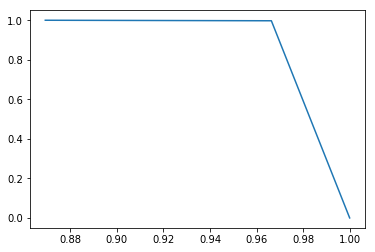

In [75]:
y_bin_true = [convert_binary(label) for label in list(y_test)] 
y_bin_predict = [convert_binary(label) for label in list(y_predicted)]

accuracy = accuracy_score(y_test, y_predicted)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_bin_true, y_bin_predict, average='binary')


print("Accuracy : ", accuracy)
print("Precision: ", precision)
print("Recall   : ", recall)
print("F1 score : ", f1_score)

print("\nP-R curve : ")
precision, recall, _ = precision_recall_curve(y_bin_true, y_bin_predict)
plt.plot(precision, recall)